# Gold Recovery

## Import Packages and Data

In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [2]:
# Import data
def read_data(file_name):
    '''Takes a csv file name and returns a pandas data frame'''
    try:
        dataframe = pd.read_csv(f'/Users/kellyshreeve/Desktop/Data-Sets/{file_name}')
    except:
        dataframe = pd.read_csv(f'/datasets/{file_name}')
    
    return dataframe

# Apply read_data function to the three files
gold_full = read_data('gold_recovery_full.csv')
gold_full.name = 'Gold Recovery Full'

gold_train = read_data('gold_recovery_train.csv')
gold_train.name = 'Gold Recovery Train'

gold_test = read_data('gold_recovery_test.csv')
gold_test.name = 'Gold Recovery Test'

# Define list of dataframes
dataframes = [gold_full, gold_train, gold_test]

# For each dataframe, print shape, info, and head
for frame in dataframes:
    print(f'{frame.name}:')   
    print(f'Shape: {frame.shape}')
    print()
    print(frame.info())
    print(frame.head(10).to_string())
    

Gold Recovery Full:
Shape: (22716, 87)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol               

In [3]:
# Change column names to snake case
dataframes = [gold_full, gold_train, gold_test]

for frame in dataframes:
    frame.columns = frame.columns.str.replace('.', '_')

/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_5556/1058002188.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  frame.columns = frame.columns.str.replace('.', '_')
/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_5556/1058002188.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  frame.columns = frame.columns.str.replace('.', '_')
/var/folders/q7/2k38l43j455fh7f8t9_wlj240000gn/T/ipykernel_5556/1058002188.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  frame.columns = frame.columns.str.replace

### Import data conclusion

Each csv has been read into python and saved as a pandas dataframe. The full dataframe has 22716 rows and 87 columns. The train dataframe has 16860 rows and 87 columns. The test dataframe has 5856 rows and 53 columns. There are 34 variables present in the training dataframe that are missing in the test set. There are missing values throughout all dataframes. The 'date' column in each data frame will need to be changed to date-time type. All other data types are correct. Periods in variable names have been changed to underscores to comply with snake case. 

## Look into Data

The calculation for rougher recovery is used to confirm correct calculation of rougher_output_recovery in the training dataframe. Missing columns in the test set are listed and explored.

### Check rougher output recovery is calculated correctly

Using the equation below, rougher concentrate recovery is re-calculated and compared to the rougher output recovery listed in the dataframe to ensure rougher concentrate recovery was calculated correctly.

![Screen Shot 2023-07-20 at 11.58.29 AM.png](<attachment:Screen Shot 2023-07-20 at 11.58.29 AM.png>)

![Screen Shot 2023-07-20 at 12.00.12 PM.png](<attachment:Screen Shot 2023-07-20 at 12.00.12 PM.png>)
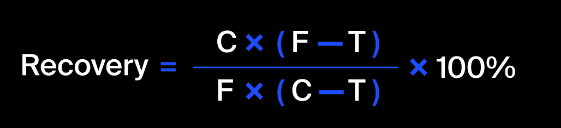
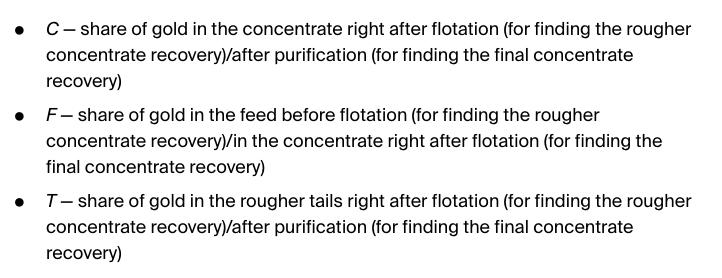

In [4]:
# Calculate rougher recovery

# Create a clean dataframe
gold_train_dropna = gold_train.dropna().copy()

# Define a function to calculate recovery
def rougher_recovery(row):
    '''Takes a row and calculates rougher output recovery'''
    # Select columns for calculation
    C = row['rougher_output_concentrate_au']
    F = row['rougher_input_feed_au']
    T = row['rougher_output_tail_au']
    
    # Calculate recovery
    recovery = ((C * (F - T)) / (F * (C - T))) * 100
    return recovery

# Use rougher_recovery function to calculate a rougher_recovery_calculated feature
gold_train_dropna['rougher_recovery_calculated'] = gold_train_dropna.apply(rougher_recovery, axis=1)

print(gold_train_dropna.head().to_string())

                  date  final_output_concentrate_ag  final_output_concentrate_pb  final_output_concentrate_sol  final_output_concentrate_au  final_output_recovery  final_output_tail_ag  final_output_tail_pb  final_output_tail_sol  final_output_tail_au  primary_cleaner_input_sulfate  primary_cleaner_input_depressant  primary_cleaner_input_feed_size  primary_cleaner_input_xanthate  primary_cleaner_output_concentrate_ag  primary_cleaner_output_concentrate_pb  primary_cleaner_output_concentrate_sol  primary_cleaner_output_concentrate_au  primary_cleaner_output_tail_ag  primary_cleaner_output_tail_pb  primary_cleaner_output_tail_sol  primary_cleaner_output_tail_au  primary_cleaner_state_floatbank8_a_air  primary_cleaner_state_floatbank8_a_level  primary_cleaner_state_floatbank8_b_air  primary_cleaner_state_floatbank8_b_level  primary_cleaner_state_floatbank8_c_air  primary_cleaner_state_floatbank8_c_level  primary_cleaner_state_floatbank8_d_air  primary_cleaner_state_floatbank8_d_level  rou

A new column has been added to the training dataframe with rougher recovery calculated from the equation.

In [5]:
# Calculate MAE of rougher_output_recovery and rougher_recovery_calculated
rougher_recovery_mae = mean_absolute_error(gold_train_dropna['rougher_output_recovery'], 
                                           gold_train_dropna['rougher_recovery_calculated'])

print(f'MAE: {rougher_recovery_mae}')

MAE: 9.460144184559453e-15


The Mean Absolute Error between the rougher recovery in the dataset and the rougher recovery calculated is almost 0. This represents no difference between the rougher recovery in the dataset and the calculated rougher recovery. The rougher output recovery in the dataset was calculated correctly.

### Explore features not in test set

In [6]:
# Find columns not in test dataframe
missing_columns_test = gold_train.columns[~gold_train.columns.isin(gold_test.columns)]

# Print missing columns
print(f'Number of columns not in test frame: {len(missing_columns_test)}')
print()
print('Names of columns not in test frame:')
print(missing_columns_test)

Number of columns not in test frame: 34

Names of columns not in test frame:
Index(['final_output_concentrate_ag', 'final_output_concentrate_pb',
       'final_output_concentrate_sol', 'final_output_concentrate_au',
       'final_output_recovery', 'final_output_tail_ag', 'final_output_tail_pb',
       'final_output_tail_sol', 'final_output_tail_au',
       'primary_cleaner_output_concentrate_ag',
       'primary_cleaner_output_concentrate_pb',
       'primary_cleaner_output_concentrate_sol',
       'primary_cleaner_output_concentrate_au',
       'primary_cleaner_output_tail_ag', 'primary_cleaner_output_tail_pb',
       'primary_cleaner_output_tail_sol', 'primary_cleaner_output_tail_au',
       'rougher_calculation_sulfate_to_au_concentrate',
       'rougher_calculation_floatbank10_sulfate_to_au_feed',
       'rougher_calculation_floatbank11_sulfate_to_au_feed',
       'rougher_calculation_au_pb_ratio', 'rougher_output_concentrate_ag',
       'rougher_output_concentrate_pb', 'rougher_ou

The columns missing in the test set are all output values.

## Prepare Data

### Check for duplicates

In [7]:
# Calculate duplicates in each dataframe
for frame in dataframes:
    duplicates = frame.duplicated().sum()
    print(f'Number of duplicates {frame.name}: {duplicates}')

Number of duplicates Gold Recovery Full: 0
Number of duplicates Gold Recovery Train: 0
Number of duplicates Gold Recovery Test: 0


There are no duplicates in any of the data frames.

### Address missing values

In [8]:
# Calculate percent of missing values for each column in each dataframe
for frame in dataframes:
    missing_count = frame.isna().sum()
    missing_percent = (missing_count/len(frame)) * 100
    missing_percent_round = missing_percent.round(2)
    
    print(f'Percent Missing in {frame.name}')
    print()
    print(f'{missing_percent_round.to_string()}')
    print()

Percent Missing in Gold Recovery Full

date                                                   0.00
final_output_concentrate_ag                            0.39
final_output_concentrate_pb                            0.38
final_output_concentrate_sol                           1.69
final_output_concentrate_au                            0.38
final_output_recovery                                  8.64
final_output_tail_ag                                   0.37
final_output_tail_pb                                   0.88
final_output_tail_sol                                  1.19
final_output_tail_au                                   0.36
primary_cleaner_input_sulfate                          7.08
primary_cleaner_input_depressant                       6.81
primary_cleaner_input_feed_size                        0.00
primary_cleaner_input_xanthate                         5.07
primary_cleaner_output_concentrate_ag                  0.43
primary_cleaner_output_concentrate_pb                  1.97
p

The percent of missing values in each column is around or below 10%. Some columns have slightly higher percentages of missing values, but none exceeding 15.26%. Because we have reason to believe observations that happened at similar times are similar on other parameters, missing values will be imputed with the average of the value before and the value after the missing value.

In [11]:
# Fill missing values with average of forward and backward fill
for frame in dataframes:
    frame.iloc[:, 1:88] = (frame.iloc[:, 1:88].ffill() 
                           + frame.iloc[:, 1:88].bfill())/2 # only numeric columns

# Re-Print percentage of missing values in each data frame
for frame in dataframes:
    missing_count = frame.isna().sum()
    missing_percent = (missing_count/len(frame)) * 100
    missing_percent_round = missing_percent.round(2)
    
    print(f'Percent Missing in {frame.name} After Imputation:')
    print()
    print(f'{missing_percent_round.to_string()}')
    print()

Percent Missing in Gold Recovery Full After Imputation:

date                                                  0.0
final_output_concentrate_ag                           0.0
final_output_concentrate_pb                           0.0
final_output_concentrate_sol                          0.0
final_output_concentrate_au                           0.0
final_output_recovery                                 0.0
final_output_tail_ag                                  0.0
final_output_tail_pb                                  0.0
final_output_tail_sol                                 0.0
final_output_tail_au                                  0.0
primary_cleaner_input_sulfate                         0.0
primary_cleaner_input_depressant                      0.0
primary_cleaner_input_feed_size                       0.0
primary_cleaner_input_xanthate                        0.0
primary_cleaner_output_concentrate_ag                 0.0
primary_cleaner_output_concentrate_pb                 0.0
primary_cleaner

### Prepare data conclusion

There are no duplicates and missing values have been imputed with tha average of forward and backward fill across all three datasets. The datasets are clean, prepared, and ready for analysis.

## Exploratory Data Analysis

### Descriptive statistics for each variable

In [ ]:
# Print descriptive statistics for each dataset
for frame in dataframes:
    descriptives = frame.describe()
    print(f'Descriptive Statistics {frame.name}:')
    print(descriptives.to_string())

Descriptive Statistics Gold Recovery Full:
       final_output_concentrate_ag  final_output_concentrate_pb  final_output_concentrate_sol  final_output_concentrate_au  final_output_recovery  final_output_tail_ag  final_output_tail_pb  final_output_tail_sol  final_output_tail_au  primary_cleaner_input_sulfate  primary_cleaner_input_depressant  primary_cleaner_input_feed_size  primary_cleaner_input_xanthate  primary_cleaner_output_concentrate_ag  primary_cleaner_output_concentrate_pb  primary_cleaner_output_concentrate_sol  primary_cleaner_output_concentrate_au  primary_cleaner_output_tail_ag  primary_cleaner_output_tail_pb  primary_cleaner_output_tail_sol  primary_cleaner_output_tail_au  primary_cleaner_state_floatbank8_a_air  primary_cleaner_state_floatbank8_a_level  primary_cleaner_state_floatbank8_b_air  primary_cleaner_state_floatbank8_b_level  primary_cleaner_state_floatbank8_c_air  primary_cleaner_state_floatbank8_c_level  primary_cleaner_state_floatbank8_d_air  primary_cleaner_sta

The means of the variables in the full, training, and test sets are similar, showing evidence that the training and test set are both representative of the full set and are similar to each other. 

### Histograms of each veriable

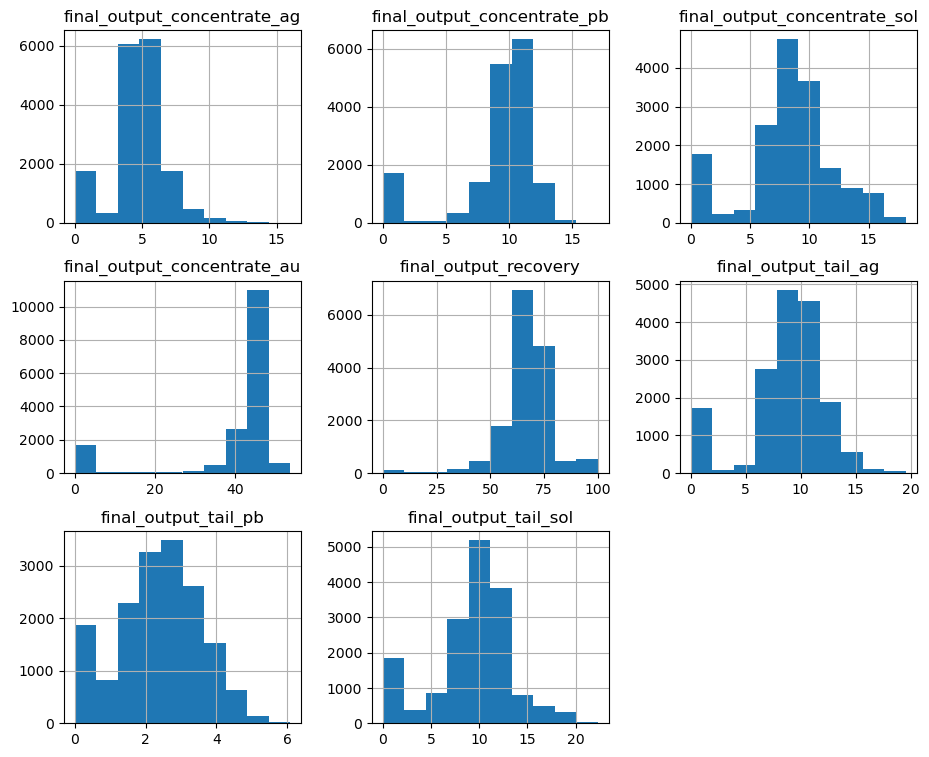

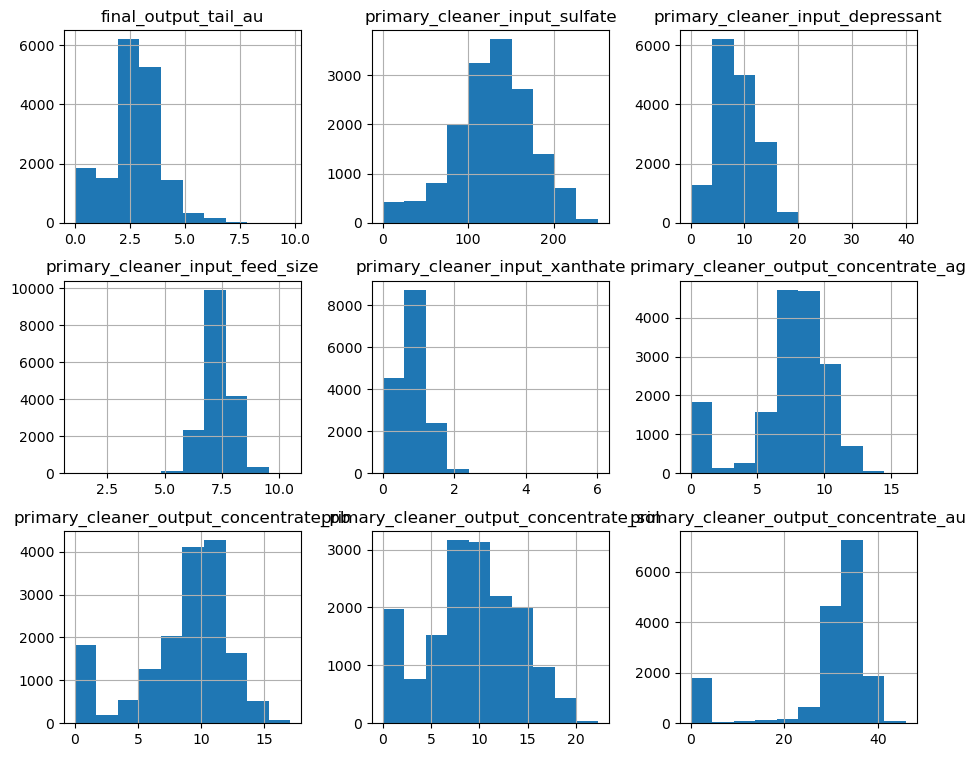

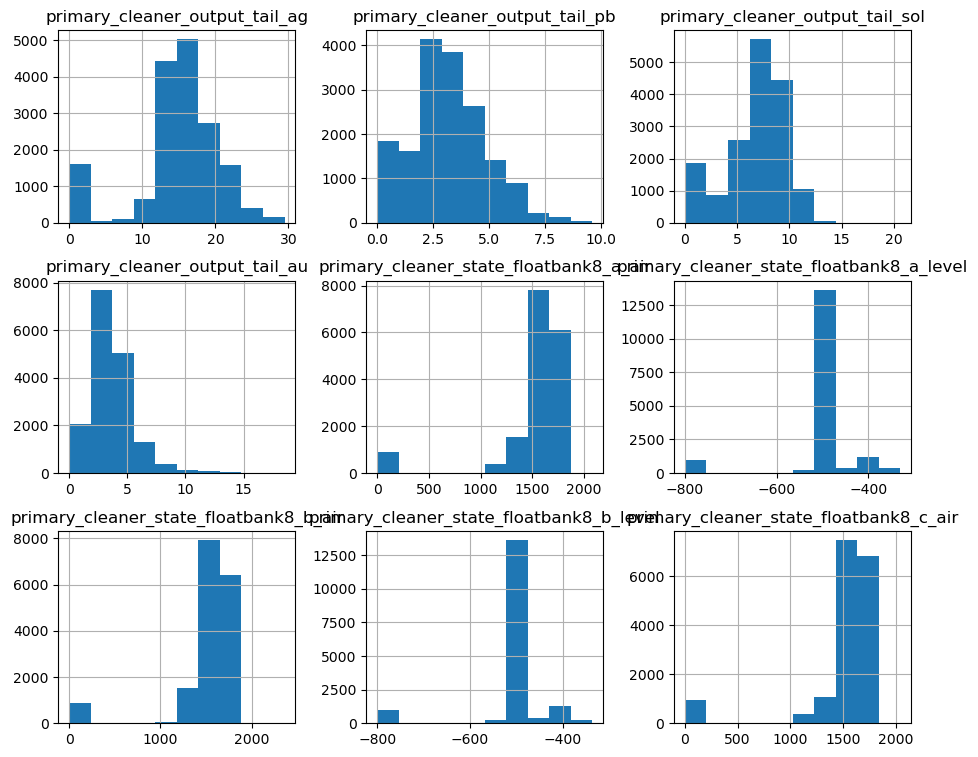

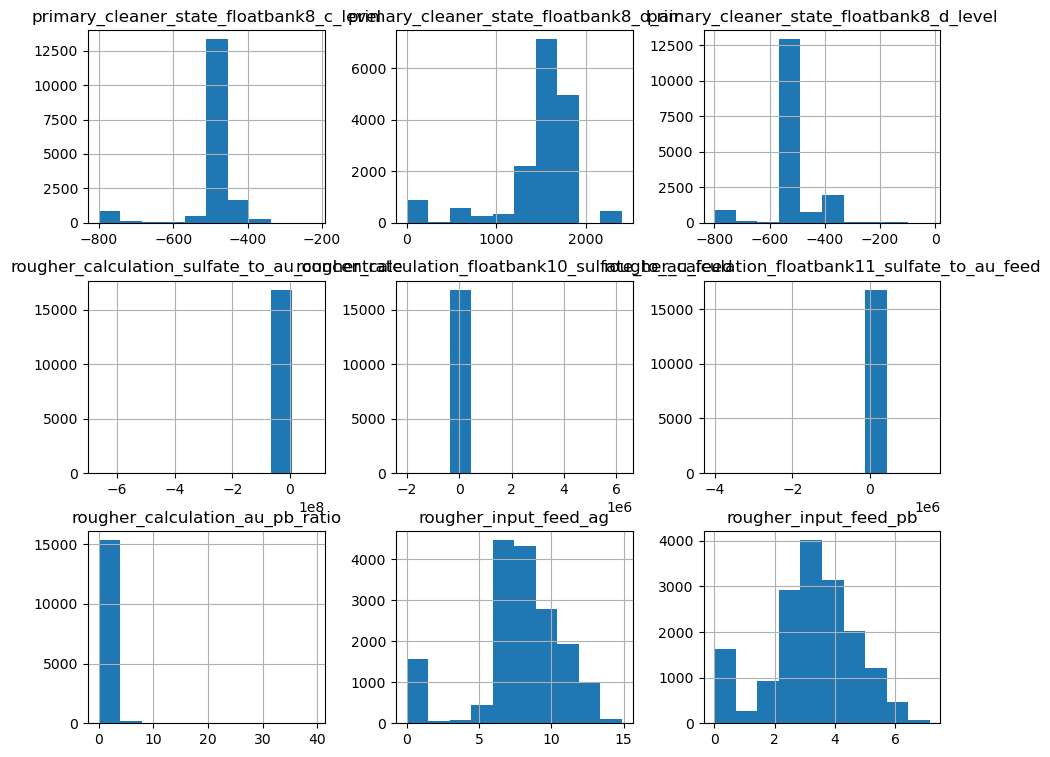

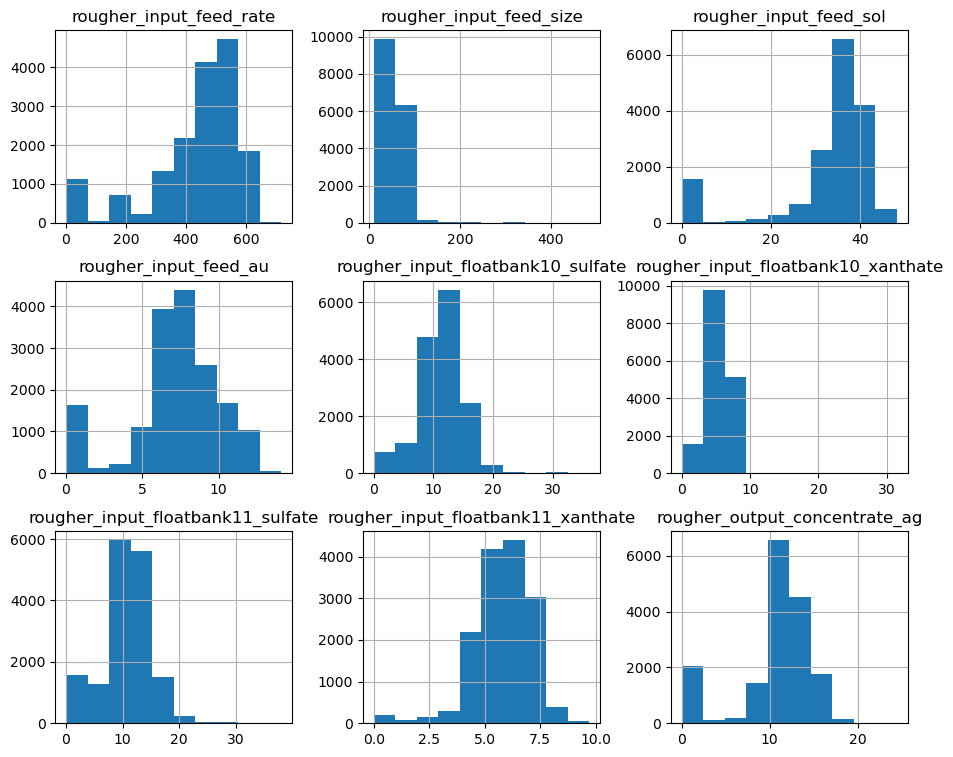

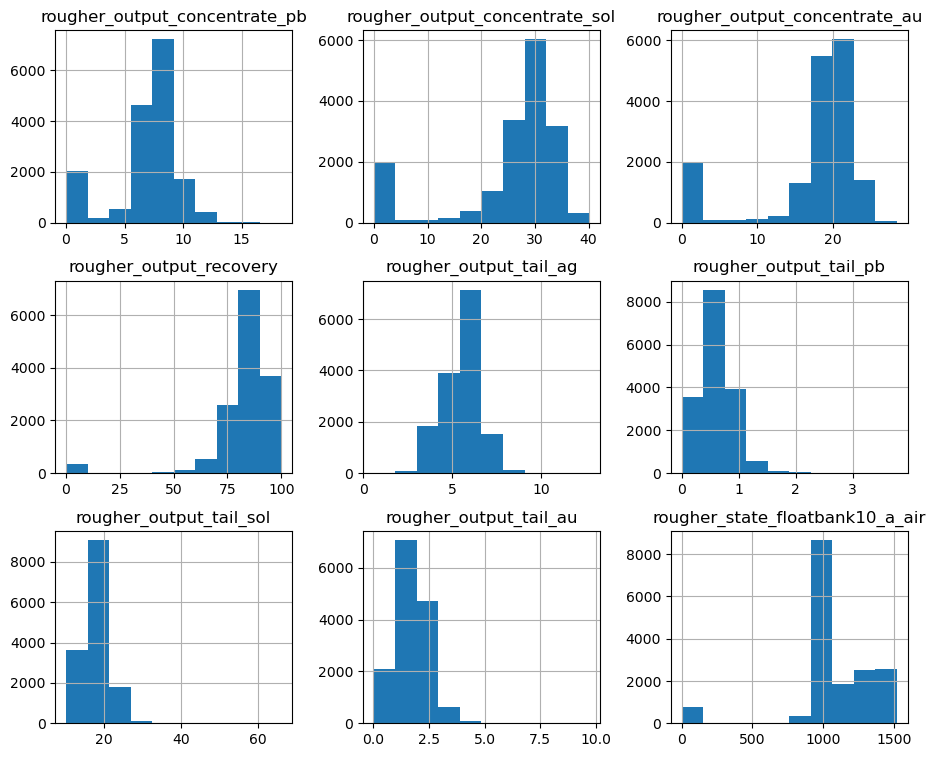

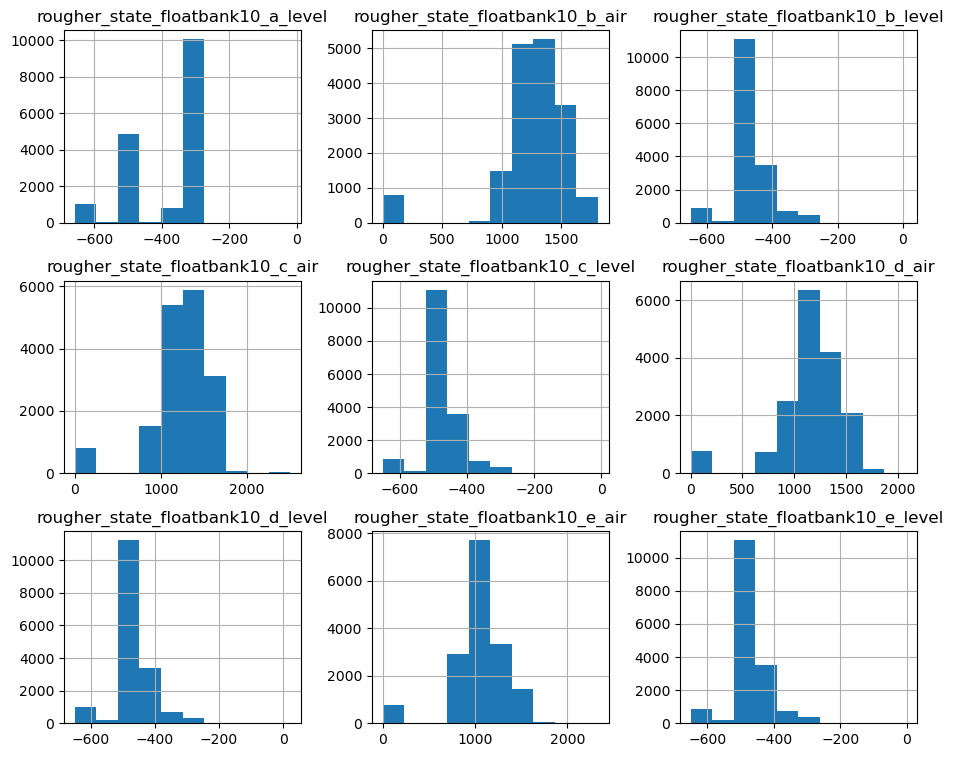

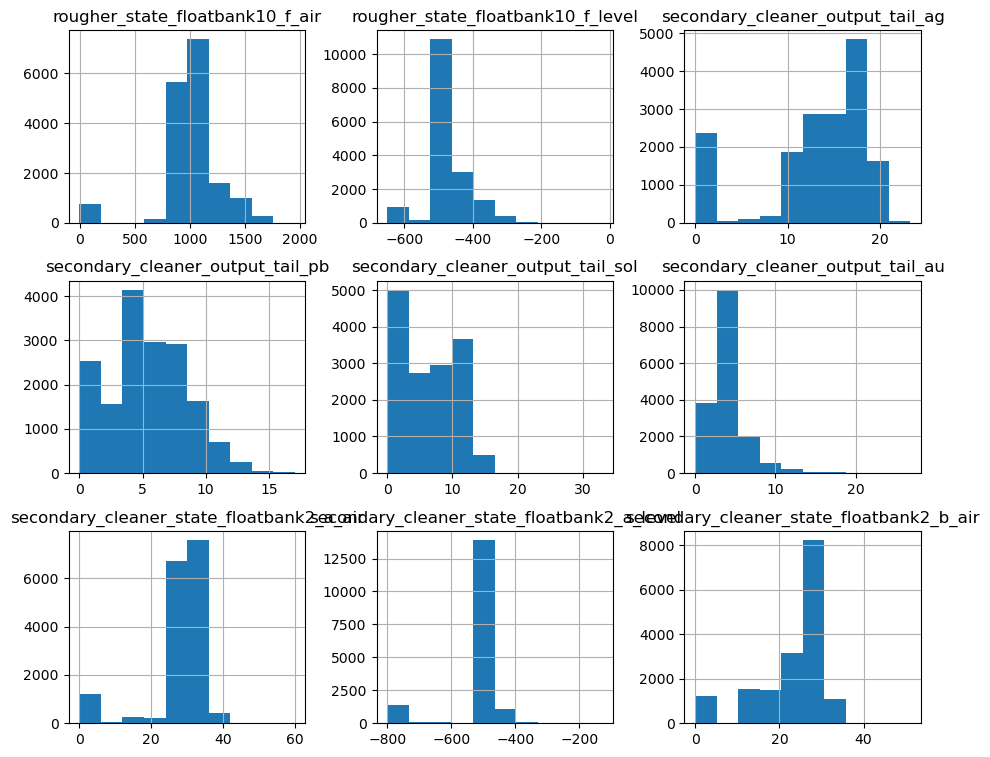

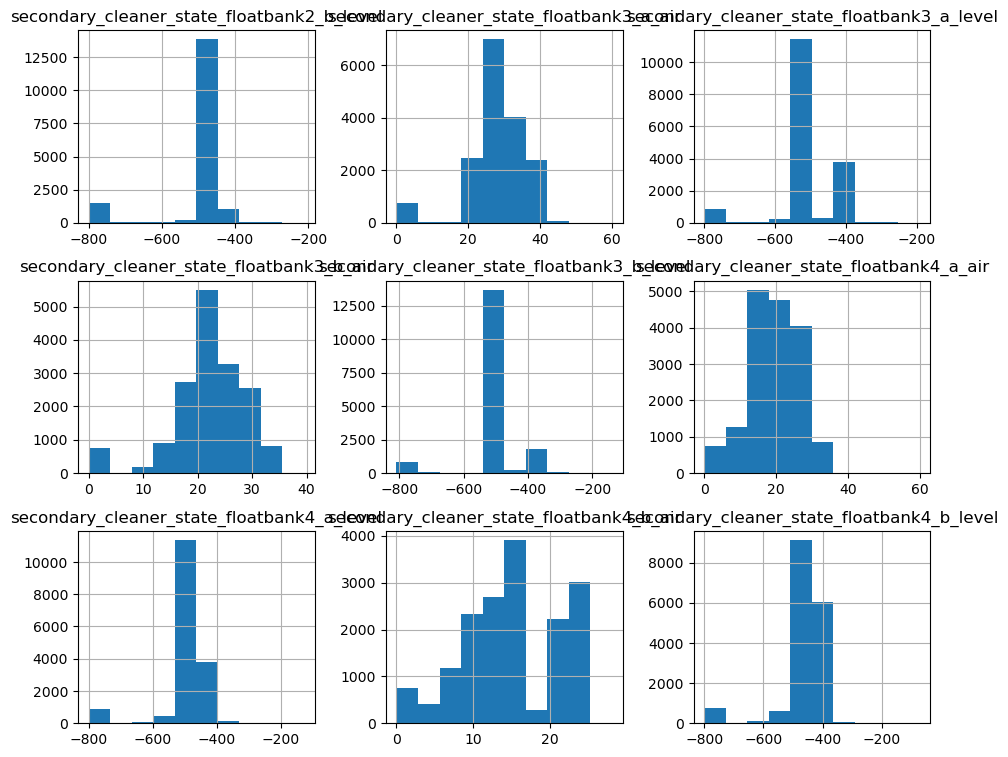

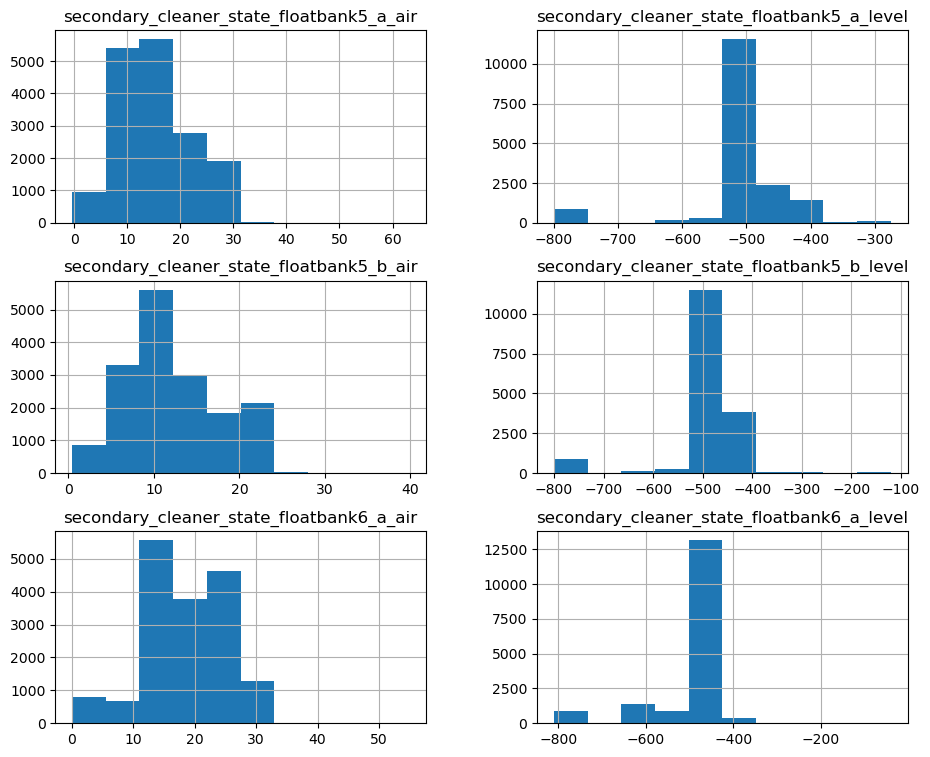

In [ ]:
# Plot histograms for each variable in the training set
for i in range(0, len(gold_train.columns), 9):
    gold_train.iloc[:, i:i+9].hist(figsize=(11, 9))
    plt.tight_layout
    plt.show()

All variables look fairly normally distributed. Most variables have an additional high bar at the lowest end of the scale. Further investigation is needed to determine if the high bars represent a group of outliers at the low end of the dataset, or if there are a mix of different observations accounting for those peaks in each variable. Importantly, the first main target variable, rougher_output_recovery, is left skewed, and the other main target variable, final_output_reocery, appears normal and doesn't have any noticeable skew.

### Concentrations of metals over purification stages

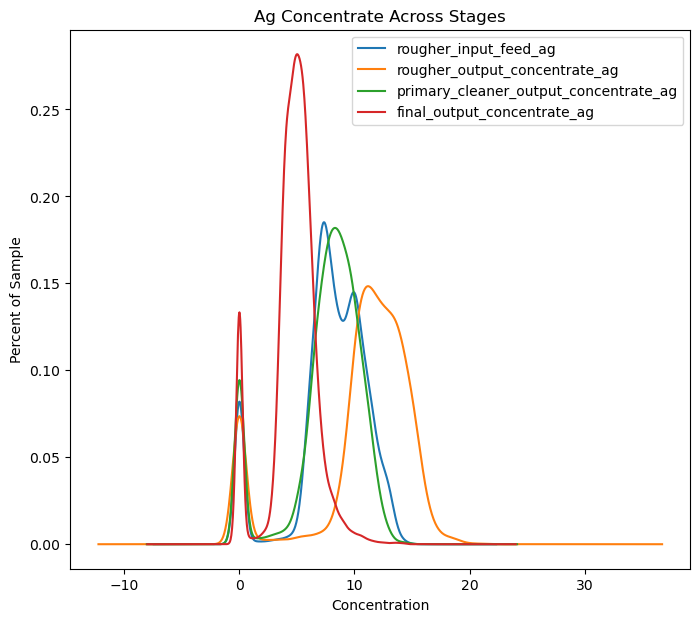

Ag Concentrate Descriptives:


,Rougher Input Feed (Ag),Rougher Output (Ag),Primary Cleaner Output (Ag),Final Output (Ag)
count,22716.00,22716.00,22716.00,22716.00
mean,8.04,10.84,7.67,4.77
std,3.15,4.41,3.13,2.04
min,0.00,0.00,0.00,0.00
25%,6.93,10.11,6.76,4.01
50%,8.29,11.77,8.26,4.95
75%,10.13,13.61,9.69,5.86
max,14.87,24.48,16.08,16.00


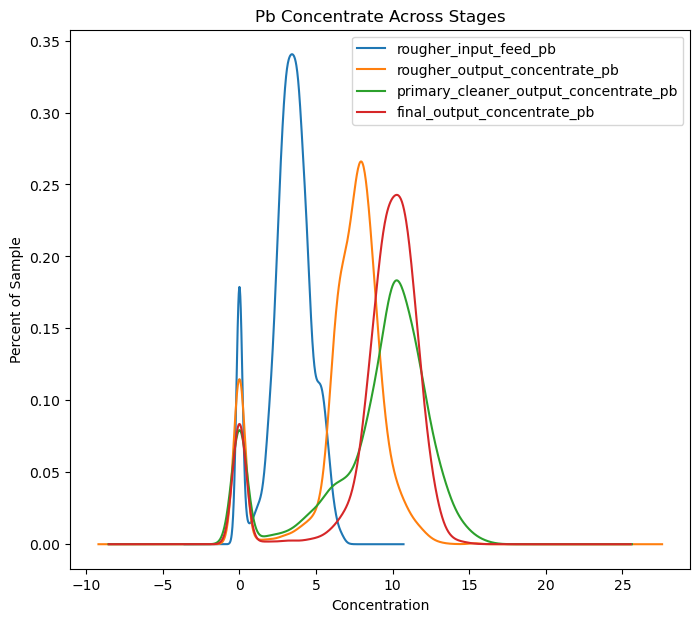

Pb Concentrate Descriptives:


,Rougher Input Feed (Pb),Rougher Output (Pb),Primary Cleaner Output (Pb),Final Output (Pb)
count,22716.00,22716.00,22716.00,22716.00
mean,3.28,6.88,8.82,9.07
std,1.46,2.83,3.76,3.26
min,0.00,0.00,0.00,0.00
25%,2.63,6.36,7.61,8.74
50%,3.42,7.57,9.88,9.91
75%,4.20,8.47,11.23,10.93
max,7.14,18.39,17.08,17.03


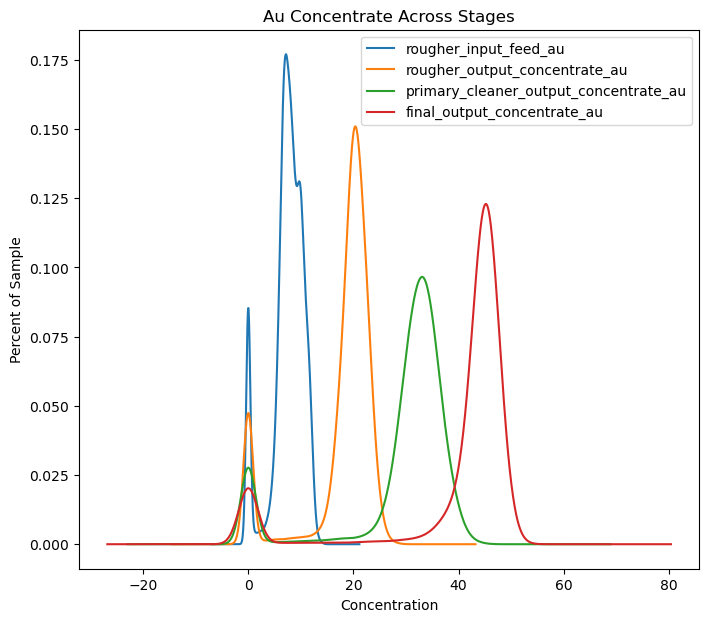

Au Concentrate Descriptives:


,Rougher Input Feed (Au),Rougher Output (Au),Primary Cleaner Output (Au),Final Output (Au)
count,22716.00,22716.00,22716.00,22716.00
mean,7.54,17.82,29.11,39.89
std,3.05,6.85,10.65,13.53
min,0.00,0.00,0.00,0.00
25%,6.47,17.89,29.33,42.35
50%,7.88,19.99,32.34,44.64
75%,9.66,21.56,34.76,46.11
max,14.09,28.82,45.93,53.61


In [55]:
# Plot histograms of metal concentrations across stages and display descriptives

metals = ['ag', 'pb', 'au']

for metal in metals:
    # plot density curve for each stage
    gold_full[f'rougher_input_feed_{metal}'].plot(kind='density', legend=True, figsize=(8, 7))
    gold_full[f'rougher_output_concentrate_{metal}'].plot(kind='density', legend=True)
    gold_full[f'primary_cleaner_output_concentrate_{metal}'].plot(kind='density', legend=True)
    gold_full[f'final_output_concentrate_{metal}'].plot(kind='density', legend=True)

    # title and axis labels
    plt.title(f'{metal.capitalize()} Concentrate Across Stages')
    plt.xlabel('Concentration')
    plt.ylabel('Percent of Sample')
    
    # display plot
    plt.show()
    
    # calculate descriptives of each stage
    descriptive_feed = gold_full[f'rougher_input_feed_{metal}'].describe().round(2)
    descriptive_rough_out = gold_full[f'rougher_output_concentrate_{metal}'].describe().round(2)
    descriptive_primary_out = gold_full[f'primary_cleaner_output_concentrate_{metal}'].describe().round(2)
    descriptive_final_out = gold_full[f'final_output_concentrate_{metal}'].describe().round(2)
    
    # combine into data frame
    averages = pd.DataFrame(data={f'Rougher Input Feed ({metal.capitalize()})':descriptive_feed,
                                  f'Rougher Output ({metal.capitalize()})':descriptive_rough_out,
                                  f'Primary Cleaner Output ({metal.capitalize()})':descriptive_primary_out,
                                  f'Final Output ({metal.capitalize()})':descriptive_final_out})
    
    # display dataframe
    print(f'{metal.capitalize()} Concentrate Descriptives:')
    display(averages)

According to the density plots and averages across stages, the the concentration of silver decreases from raw feed input to final output, while concentrations of lead and gold increase across the stages. The concentration of silver begins at a moderate level in the initial feed (M = 8.04), increases in the rougher output (M = 10.84), then decreases again in the primary cleaner output (M = 7.67) and final output (M = 4.77). The average final concentration of silver is about 3 points lower than the average concentration in initial feed. The concentration of lead increases from the initial feed (M = 3.28) to rougher output (M = 6.88) and then again in the primarly cleaner output (M = 8.82). There is only a small increase in mean concentration from the primary cleaner output (M = 8.82) to the final output (M = 9.07). The average concentration of lead is about 6 points higher in the final output than the initial feed. The concentration of gold steadily increase across all stages from rougher input (M = 7.54), to rougher output (M = 17.82), to primarly cleaner output (M = 29.11), and finally final output (M = 39.89). The average final output concentration of gold is over 30 points higher than the average inital feed concentration. While both gold and lead see increases in concentration from input to final output, gold sees a far larger increase in concentration and a final concentration four times higher than that of lead. It is likely that silver and other solids are being filtered out of the material across the stages, leaving mostly gold and some lead behind.

### Compare feed particle size in training vs test sets

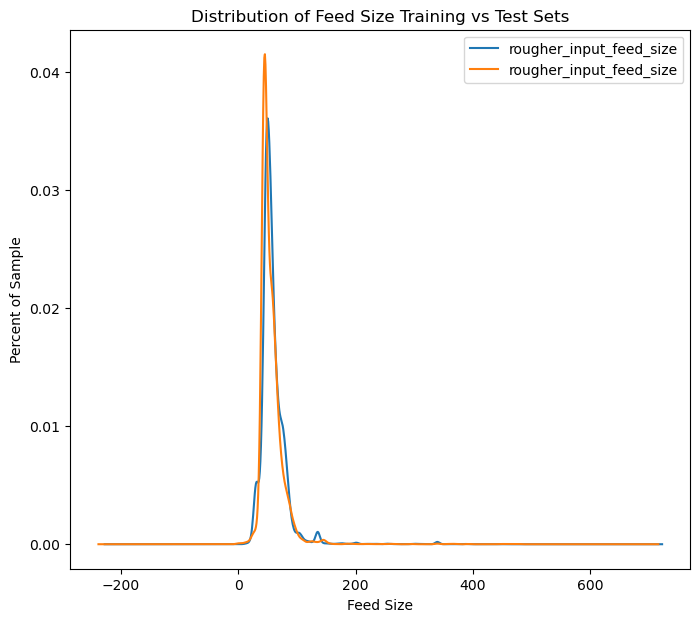

In [56]:
# Plot density histogram of rougher input feed size in training and test sets
gold_train['rougher_input_feed_size'].plot(kind='density', legend=True, figsize=(8, 7))
gold_test['rougher_input_feed_size'].plot(kind='density', legend=True)

plt.title('Distribution of Feed Size Training vs Test Sets')
plt.xlabel('Feed Size')
plt.ylabel('Percent of Sample')

plt.show()

The density histogram of feed size in the test set almost perfectly overlays the density histogram of feed size in the training set. This means the distribution of feed size in the test set is almost identical to the distribution of feed size in the training set. Therefore our trianing and test sets are reasonably split and similar to each other. I don't expect there to be any issues with model evaluation that are due to differences in the sets.

### Total concentration of all substances across the stages

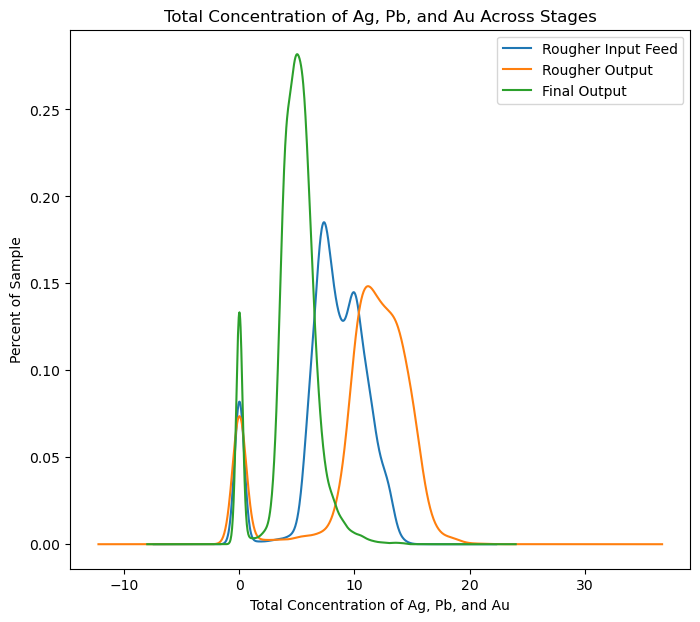

In [59]:
# Calculate total of Ag, Pb, and Au at each stage
gold_full['total_feed_input'] = gold_full['rougher_input_feed_ag'] 
+ gold_full['rougher_input_feed_pb'] 
+ gold_full['rougher_input_feed_au']

gold_full['total_rougher_concentrate'] = gold_full['rougher_output_concentrate_ag']
+ gold_full['rougher_output_concentrate_pb']
+ gold_full['rougher_output_concentrate_au']

gold_full['total_final_concentrate'] = gold_full['final_output_concentrate_ag']
+ gold_full['final_output_concentrate_pb']
+ gold_full['final_output_concentrate_au']

# Plot density hitograms of the totals                   
gold_full['total_feed_input'].plot(kind='density', legend=True, figsize=(8, 7))
gold_full['total_rougher_concentrate'].plot(kind='density', legend=True)
gold_full['total_final_concentrate'].plot(kind='density', legend=True)

plt.title('Total Concentration of Ag, Pb, and Au Across Stages')
plt.xlabel('Total Concentration of Ag, Pb, and Au')
plt.ylabel('Percent of Sample')
plt.legend(['Rougher Input Feed','Rougher Output', 'Final Output'])

plt.show()

Examining the density histograms of total concentration of metals at each stage, there is a noticable peak at a total concentration of 0. This represents samples that are recorded as have no Ag, Pb, or Au in them. This could be due to the samples containing very little or no metal in them or due to data missing for these observations. Either way, samples recorded as having no metal concentration are not useful for predicting recovery and will be removed from both the training and test set.

In [72]:
# Find samples with total concentrations around 0
no_metal_full = gold_full[gold_full['total_final_concentrate'] == 0 ]

print('Rows where total final concentrate is 0:')
print()
print(f'Shape: {no_metal_full.shape}')
print()
print('Data Frame:')
display(no_metal_full.head())

Rows where total final concentrate is 0:

Shape: (1669, 90)

Data Frame:


,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level,total_feed_input,total_rougher_concentrate,total_final_concentrate
99,2016-01-19 03:00:00,0.0,0.0,0.0,0.0,40.654173,0.0,0.0,0.0,0.0,...,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756,0.0,0.0,0.0
100,2016-01-19 04:00:00,0.0,0.0,0.0,0.0,40.654173,0.0,0.0,0.0,0.0,...,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301,0.0,0.0,0.0
101,2016-01-19 05:00:00,0.0,0.0,0.0,0.0,40.654173,0.0,0.0,0.0,0.0,...,-638.103348,9.956309,-499.791870,7.978806,-500.202026,11.987839,-600.302819,0.0,0.0,0.0
102,2016-01-19 06:00:00,0.0,0.0,0.0,0.0,40.654173,0.0,0.0,0.0,0.0,...,-641.310327,9.966952,-499.842458,8.053455,-499.588522,11.987935,-600.523057,0.0,0.0,0.0
103,2016-01-19 07:00:00,0.0,0.0,0.0,0.0,40.654173,0.0,0.0,0.0,0.0,...,-641.457227,10.033820,-501.291438,7.985956,-499.934267,12.027556,-600.108918,0.0,0.0,0.0


There are 1669 rows in the full dataframe that have total final concentrate of metals equal to zero. These represent rows where the sample didn't contain any metals. These rows with be removed from the training and target sets.

In [83]:
# Find rows with no metal in training set
no_metal_train = gold_train[gold_train['date'].isin(no_metal_full['date'])]

# Find rows with no metal in test set
no_metal_test = gold_test[gold_test['date'].isin(no_metal_full['date'])]

# Print result
print('Rows with no metal training set:')
print()
print(f'Shape: {no_metal_train.shape}')
print()
print('Data Frame:')
display(no_metal_train)

print('Rows with no metal test set:')
print()
print(f'Shape: {no_metal_test.shape}')
print()
print('Data Frame:')
display(no_metal_test)

Rows with no metal training set:

Shape: (1318, 87)

Data Frame:


,date,final_output_concentrate_ag,final_output_concentrate_pb,final_output_concentrate_sol,final_output_concentrate_au,final_output_recovery,final_output_tail_ag,final_output_tail_pb,final_output_tail_sol,final_output_tail_au,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
99,2016-01-19 03:00:00,0.0,0.0,0.0,0.0,40.654173,0.000000,0.000000,0.000000,0.000000,...,13.985160,-799.601232,12.036072,-603.234250,9.974968,-497.092974,7.953962,-499.698442,11.941642,-598.541756
100,2016-01-19 04:00:00,0.0,0.0,0.0,0.0,40.654173,0.000000,0.000000,0.000000,0.000000,...,14.034374,-799.600946,12.040491,-623.446329,9.898782,-499.623262,7.979302,-500.283366,11.959950,-600.998301
101,2016-01-19 05:00:00,0.0,0.0,0.0,0.0,40.654173,0.000000,0.000000,0.000000,0.000000,...,13.943929,-799.600659,12.040238,-638.103348,9.956309,-499.791870,7.978806,-500.202026,11.987839,-600.302819
102,2016-01-19 06:00:00,0.0,0.0,0.0,0.0,40.654173,0.000000,0.000000,0.000000,0.000000,...,14.040873,-799.600372,12.030771,-641.310327,9.966952,-499.842458,8.053455,-499.588522,11.987935,-600.523057
103,2016-01-19 07:00:00,0.0,0.0,0.0,0.0,40.654173,0.000000,0.000000,0.000000,0.000000,...,13.972371,-799.600085,12.021058,-641.457227,10.033820,-501.291438,7.985956,-499.934267,12.027556,-600.108918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12056,2018-01-30 07:59:59,0.0,0.0,0.0,0.0,36.877842,0.000000,0.000000,0.000000,0.000000,...,19.979025,-569.020440,15.068404,-499.966176,10.950164,-499.910890,9.016255,-499.821464,11.006784,-499.988820
12057,2018-01-30 08:59:59,0.0,0.0,0.0,0.0,36.877842,0.000000,0.000000,0.000000,0.000000,...,20.050095,-520.480159,15.095624,-500.059731,10.904404,-500.296086,8.977819,-500.072435,10.985998,-500.329522
12058,2018-01-30 09:59:59,0.0,0.0,0.0,0.0,0.000000,4.404202,0.810326,2.393725,1.520501,...,19.957507,-497.933428,15.145628,-499.659056,11.068138,-497.745697,9.013462,-499.593422,11.023013,-497.588181
12059,2018-01-30 10:59:59,0.0,0.0,0.0,0.0,0.000000,10.344968,2.570687,2.393725,5.237595,...,19.928745,-500.679848,14.925877,-500.208045,10.987529,-499.505996,9.029340,-500.081496,10.978063,-500.533248


Rows with no metal test set:

Shape: (351, 53)

Data Frame:


,date,primary_cleaner_input_sulfate,primary_cleaner_input_depressant,primary_cleaner_input_feed_size,primary_cleaner_input_xanthate,primary_cleaner_state_floatbank8_a_air,primary_cleaner_state_floatbank8_a_level,primary_cleaner_state_floatbank8_b_air,primary_cleaner_state_floatbank8_b_level,primary_cleaner_state_floatbank8_c_air,...,secondary_cleaner_state_floatbank4_a_air,secondary_cleaner_state_floatbank4_a_level,secondary_cleaner_state_floatbank4_b_air,secondary_cleaner_state_floatbank4_b_level,secondary_cleaner_state_floatbank5_a_air,secondary_cleaner_state_floatbank5_a_level,secondary_cleaner_state_floatbank5_b_air,secondary_cleaner_state_floatbank5_b_level,secondary_cleaner_state_floatbank6_a_air,secondary_cleaner_state_floatbank6_a_level
30,2016-09-02 06:59:59,65.684173,4.301640,7.16,0.448300,412.629243,-795.316337,413.703253,-787.396567,441.604260,...,6.576244,-616.550019,4.625908,-678.347958,4.451592,-795.337422,3.544708,-800.024373,5.914889,-799.501783
31,2016-09-02 07:59:59,5.039223,4.301640,7.16,0.448300,1436.850397,-542.923353,1549.140548,-528.601849,1548.664773,...,11.935144,-496.491878,7.967571,-527.714564,8.191769,-517.004063,4.906812,-531.125899,10.002271,-527.901468
32,2016-09-02 08:59:59,0.857926,4.301640,7.16,0.448300,1435.627557,-499.752988,1550.871908,-500.348180,1513.760138,...,11.921123,-500.796461,7.988670,-501.212454,8.067387,-501.622580,5.067141,-499.295523,9.989370,-500.350093
33,2016-09-02 09:59:59,24.616337,0.600245,7.16,0.196905,1437.685689,-498.718550,1549.223455,-498.417613,1510.244855,...,12.002664,-499.113047,8.061677,-495.442389,8.079009,-495.166033,5.171338,-479.361256,10.056638,-498.991980
247,2016-09-11 07:59:59,7.818930,6.747213,7.83,0.098264,1300.136686,-752.693115,1302.232594,-575.075180,1299.605868,...,8.022703,-520.809679,4.954530,-569.697771,7.900118,-513.604732,2.960581,-499.693953,19.998444,-734.132064
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5737,2017-12-27 01:59:59,197.107932,15.696805,7.91,0.493329,1600.811851,-402.965168,1600.952134,-393.628997,1256.240557,...,20.007601,-499.970896,15.121014,-500.777210,10.959450,-499.720182,9.030626,-500.236071,12.002080,-500.797474
5738,2017-12-27 02:59:59,187.944247,15.025485,7.91,0.507069,1602.429263,-406.211301,1599.063975,-399.015960,1262.752085,...,20.009605,-504.462036,15.100714,-500.992188,11.034404,-501.982746,8.960953,-500.227344,12.008632,-500.506359
5749,2017-12-27 13:59:59,2.620827,8.000915,7.20,0.004011,1394.344676,-771.082673,1394.143700,-777.498223,1398.281341,...,19.962331,-797.550678,14.999044,-798.207155,10.961253,-797.003879,8.987172,-800.059438,12.016949,-804.138159
5750,2017-12-27 14:59:59,25.265934,1.018289,7.20,0.246409,1401.378244,-379.740038,1399.558611,-361.146822,1395.224375,...,19.932038,-796.602342,14.874312,-797.412056,10.998649,-795.729203,9.012115,-800.036707,12.007234,-804.516517


In [85]:
test_set_complete = gold_full[gold_full['date'].isin(gold_test['date'])]

print(test_set_complete.head(100).to_string())

                     date  final_output_concentrate_ag  final_output_concentrate_pb  final_output_concentrate_sol  final_output_concentrate_au  final_output_recovery  final_output_tail_ag  final_output_tail_pb  final_output_tail_sol  final_output_tail_au  primary_cleaner_input_sulfate  primary_cleaner_input_depressant  primary_cleaner_input_feed_size  primary_cleaner_input_xanthate  primary_cleaner_output_concentrate_ag  primary_cleaner_output_concentrate_pb  primary_cleaner_output_concentrate_sol  primary_cleaner_output_concentrate_au  primary_cleaner_output_tail_ag  primary_cleaner_output_tail_pb  primary_cleaner_output_tail_sol  primary_cleaner_output_tail_au  primary_cleaner_state_floatbank8_a_air  primary_cleaner_state_floatbank8_a_level  primary_cleaner_state_floatbank8_b_air  primary_cleaner_state_floatbank8_b_level  primary_cleaner_state_floatbank8_c_air  primary_cleaner_state_floatbank8_c_level  primary_cleaner_state_floatbank8_d_air  primary_cleaner_state_floatbank8_d_level  